# 7T micapipe processing | group level

# Thickness

In [23]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
from nilearn import plotting # only to plot the matrices
import scipy.stats as ss
import seaborn as sns

# CHECK seaborn color paletes:
#   https://seaborn.pydata.org/tutorial/color_palettes.html


def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket'):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Function 2
def vectorized_mtx(connectome_matrix):
    '''
    This function will: 
    a) vectorize the upper triangle
    b) convert the array into pandas dataframe 
    
    Parameters
    ----------
    connectome_matrix : np.array
    Returns
    -------
    df_feat_flat : Single column pandas dataframe of edges
    
    '''
    
    # Extract lower (or upper) triangle entrees (excluding diagonal)
    tril_idx = np.tril_indices(len(connectome_matrix),k=1) 
    features_flat = connectome_matrix[tril_idx]
    #print(f'Number of features per subject: {len(features_flat)}')
            
    return features_flat

def load_mpc(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_mpc = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T
    
    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    return MPC

def load_gd(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_gd = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)
    
    return GD

def load_fc(File, Ndim, parc=''):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_fs = np.loadtxt(File, dtype=float, delimiter=' ')
    
    # slice the matrix remove subcortical nodes and cerebellum
    FC = mtx_fs[49:, 49:]
    
    # Remove the medial wall
    #if parc != 'glasser-360':
    #    FC = np.delete(np.delete(FC, Ndim, axis=0), Ndim, axis=1)
    
    # Fishcer transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return FCz

def load_sc(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_sc = np.loadtxt(File, dtype=np.float, delimiter=' ')
    
    # Mirror the matrix
    mtx_sc = np.log(np.triu(mtx_sc,1)+mtx_sc.T)
    mtx_sc[np.isneginf(mtx_sc)] = 0
    
    # slice the matrix remove subcortical nodes and cerebellum
    SC = mtx_sc[49:, 49:]
    SC = np.delete(np.delete(SC, Ndim, axis=0), Ndim, axis=1)
    
    # replace 0 values with almost 0
    SC[SC==0] = np.finfo(float).eps
    
    return SC

# Set the working directory to load the helper functions
os.chdir("/host/yeatman/local_raid/rcruces/git_here/micapipe-supplementary")

# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0')

# Load conte69
c69_lh, c69_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('/data_/mica3/BIDS_PNI/derivatives_dev/fastsurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('/data_/mica3/BIDS_PNI/derivatives_dev/fastsurfer/fsaverage5/surf/rh.pial', itype='fs')

# Variables
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# Here we define the atlas
atlas='glasser-360' # 'aparc-a2009s' 'schaefer-400'

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

# mask of the medial wall
mask_c69 = labels_c69 != 0

# Load annotation file in fsaverage5
annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.'+atlas+'_mics.annot')
Ndim = max(np.unique(annot_lh_fs5[0]))
annot_rh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/rh.'+atlas+'_mics.annot')[0]+Ndim

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

In [11]:
th_lh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-L_surf-fsLR-32k_label-thickness.func.gii'))
th_rh_files=sorted(glob.glob('sub-*/ses-*/maps/*_hemi-R_surf-fsLR-32k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(th_lh_files[0]).darrays[0].data, nb.load(th_rh_files[0]).darrays[0].data), axis=0).shape[0]

th=np.empty([len(th_lh_files), Nth], dtype=float)
for i, f in enumerate(th_lh_files):
    #print(f)
    th[i,:] = np.hstack(np.concatenate((nb.load(th_lh_files[i]).darrays[0].data, nb.load(th_rh_files[i]).darrays[0].data), axis=0))

## Visualize the thickness matrix

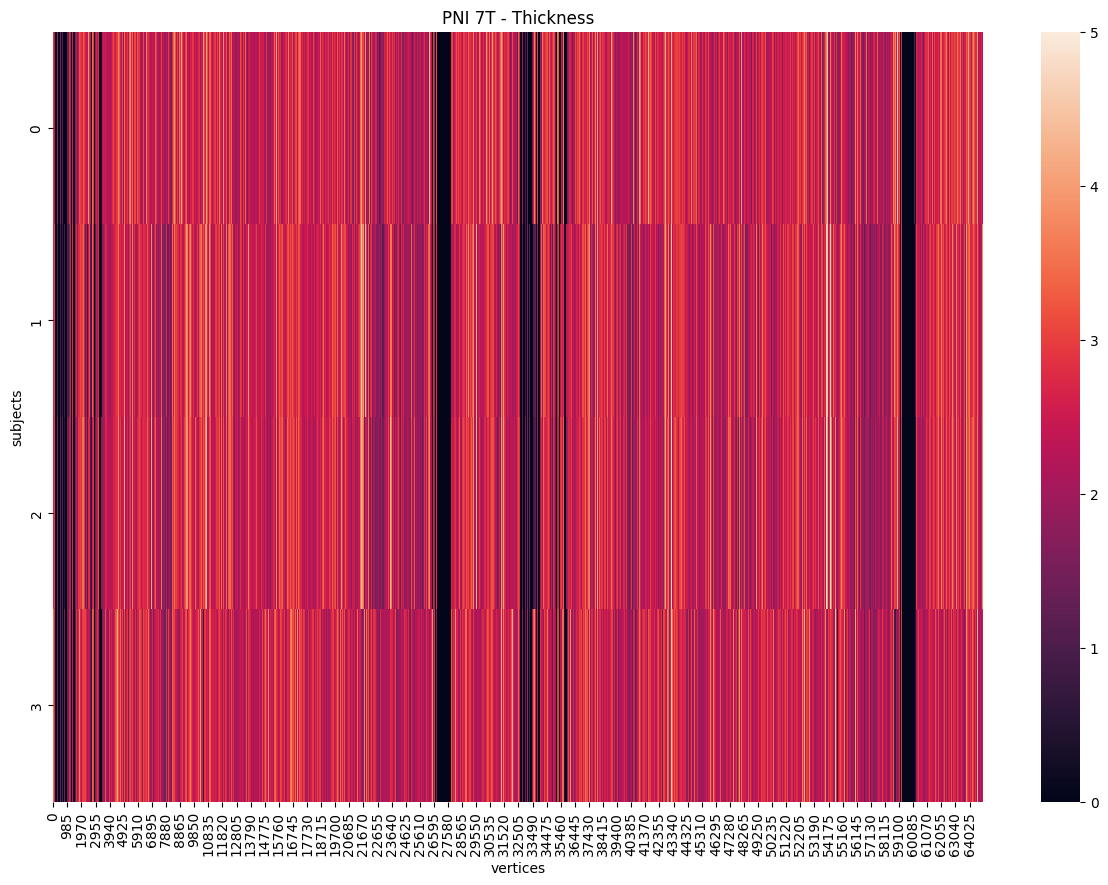

In [13]:
# Visualize the thickness matrix
plot_connectome(th, 'PNI 7T - Thickness', xlab='vertices', ylab='subjects', col='rocket')

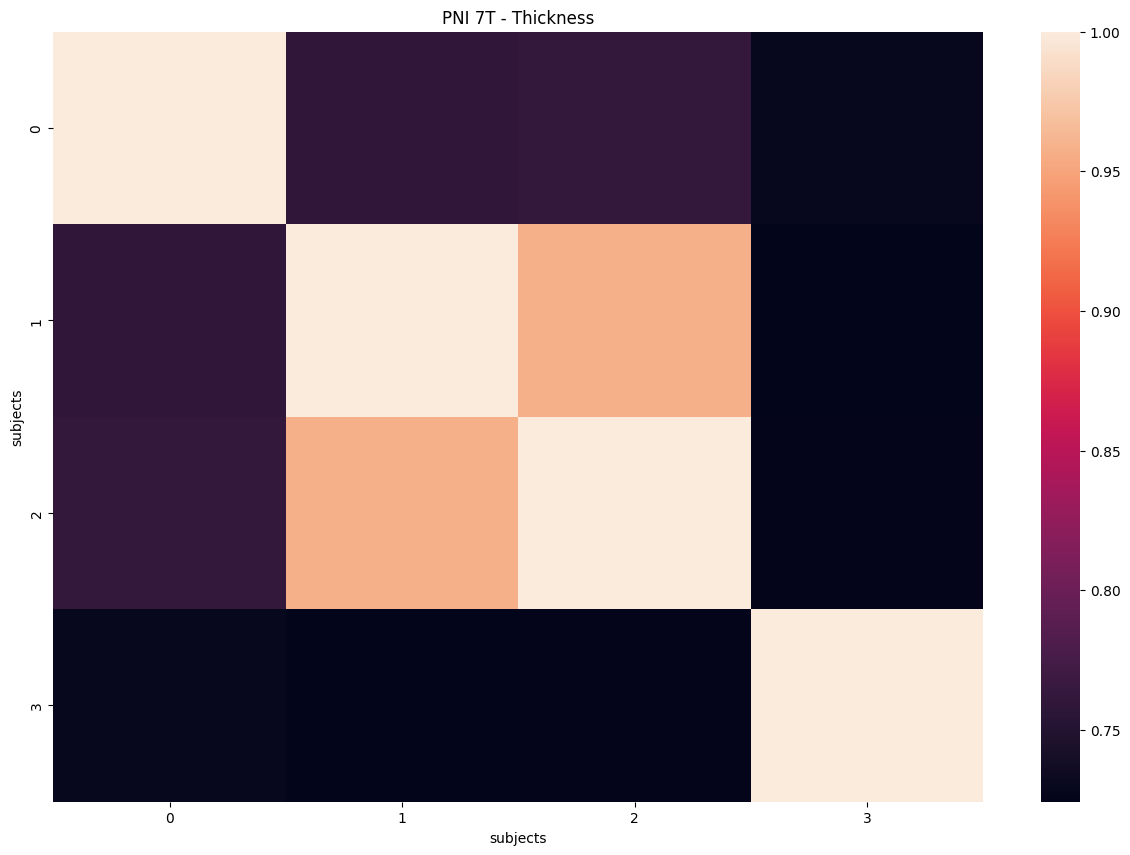

In [14]:
## correlation matrix
th_corr = np.corrcoef(th)
plot_connectome(th_corr, 'PNI 7T - Thickness', xlab='subjects', ylab='subjects')

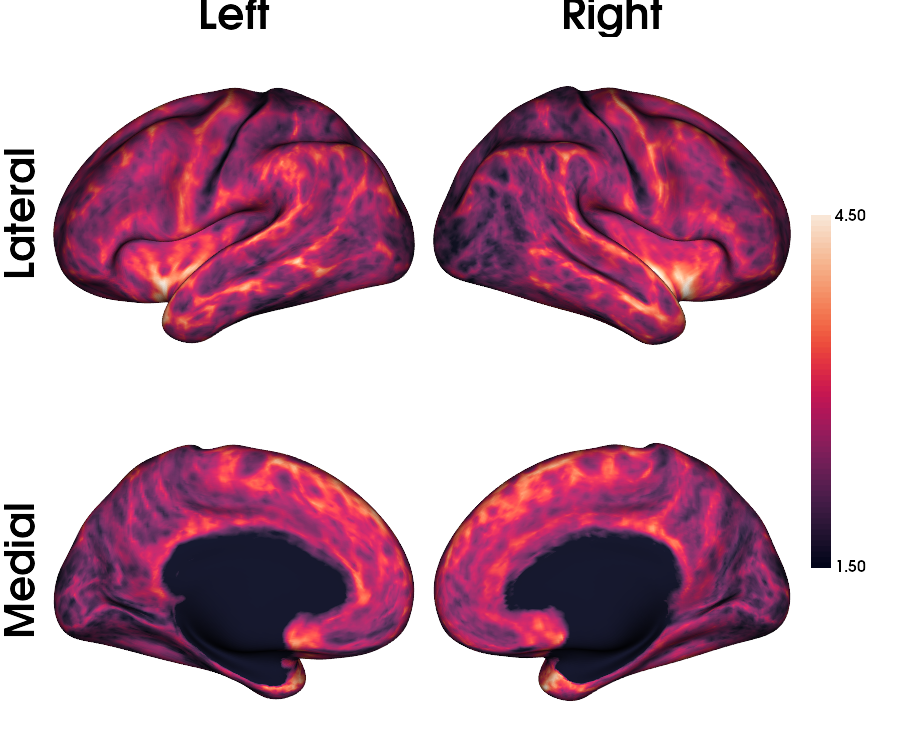

In [21]:
# Mean matrix across the x axis (vertices)
thmean = np.mean(th, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(inf_lh, inf_rh, array_name=thmean, cmap='rocket', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1.5, 4.5),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_thickness_mean.png')

# Geodesic distance

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_1486/348070376.py:79: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mtx_gd = np.loadtxt(File, dtype=np.float, delimiter=' ')


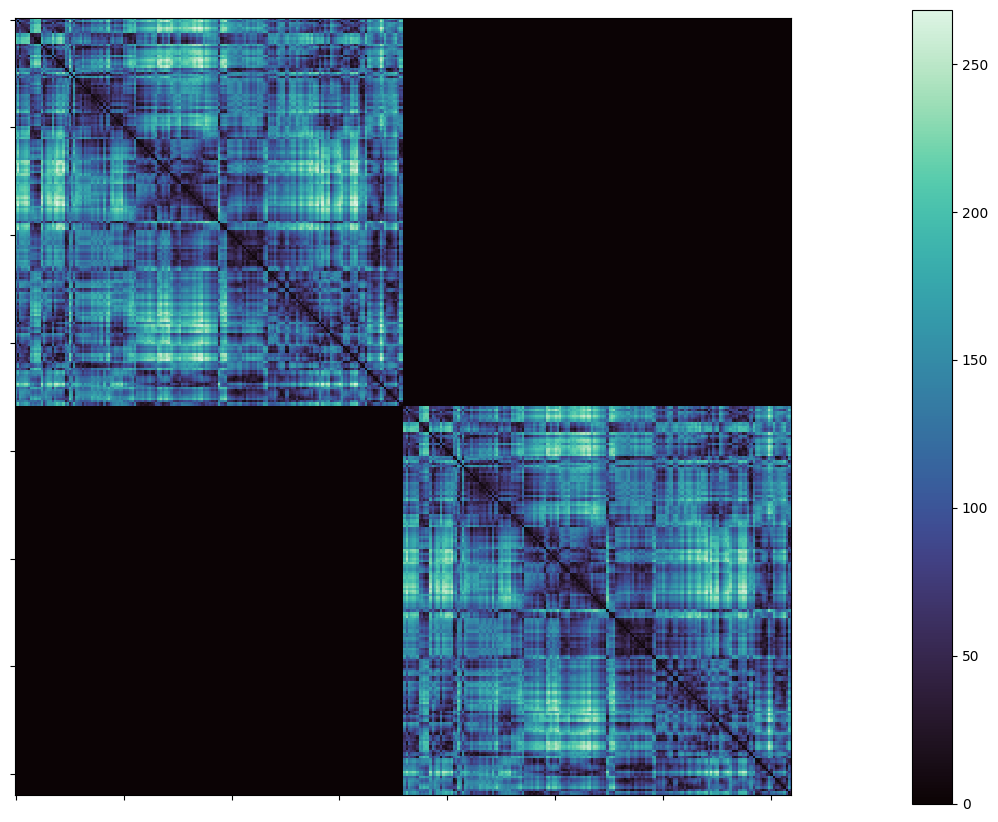

In [7]:
# list of all files
GD_files = sorted(glob.glob('sub-*/ses-*/dist/*_space-fsnative_atlas-'+atlas+'_GD.txt'))

# Load all the  MPC matrices as array
GD=np.empty([Ndim*2, Ndim*2, len(GD_files)], dtype=float)
for i, f in enumerate(GD_files):
    #print(f)
    GD[:,:,i] = load_gd(f, Ndim)
    
# Mean matrix across the z axis
GDmean = np.mean(GD, axis=2)
            
# Plot the log matrix
plotting.plot_matrix(GDmean, figure=(10, 10), labels=None, cmap='mako')

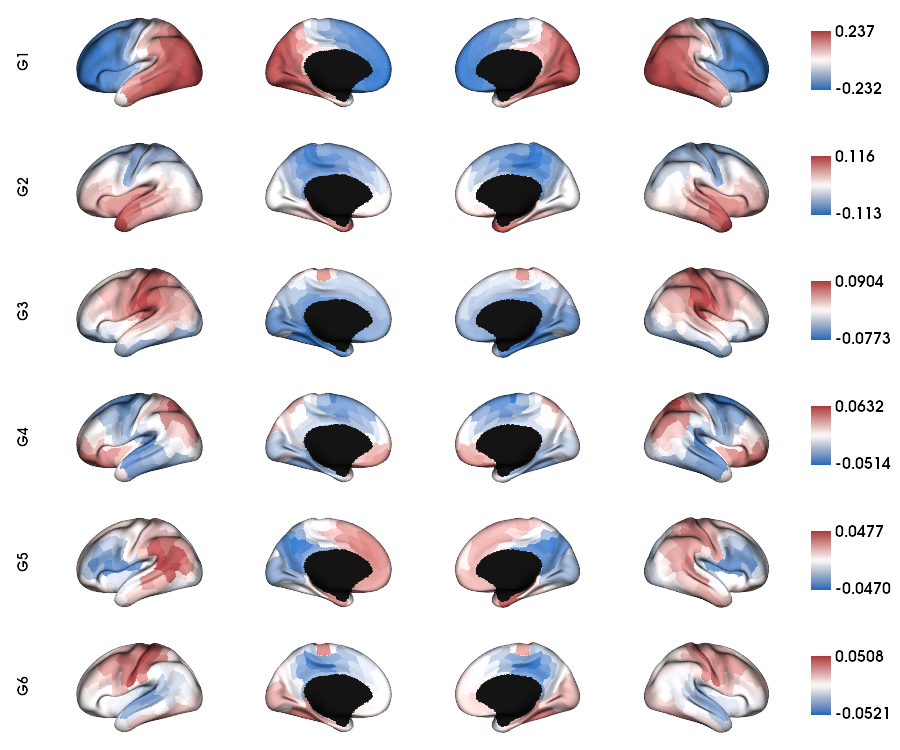

In [8]:
Ngrads=6

# GD Left hemi
gm_GD_L = GradientMaps(n_components=Ngrads, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD_L.fit(GDmean[0:Ndim, 0:Ndim], sparsity=0.8)
            
# GD Right hemi
gm_GD_R = GradientMaps(n_components=Ngrads, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_R.fit(GDmean[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.8, reference=gm_GD_L.gradients_)
             
# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD_L.gradients_, gm_GD_R.aligned_), axis=0)

# Map gradients to original parcels
grad = [None] * Ngrads
for i, g in enumerate(GD_gradients.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='vlag', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True,
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/GD_mean'+atlas+'.png')  

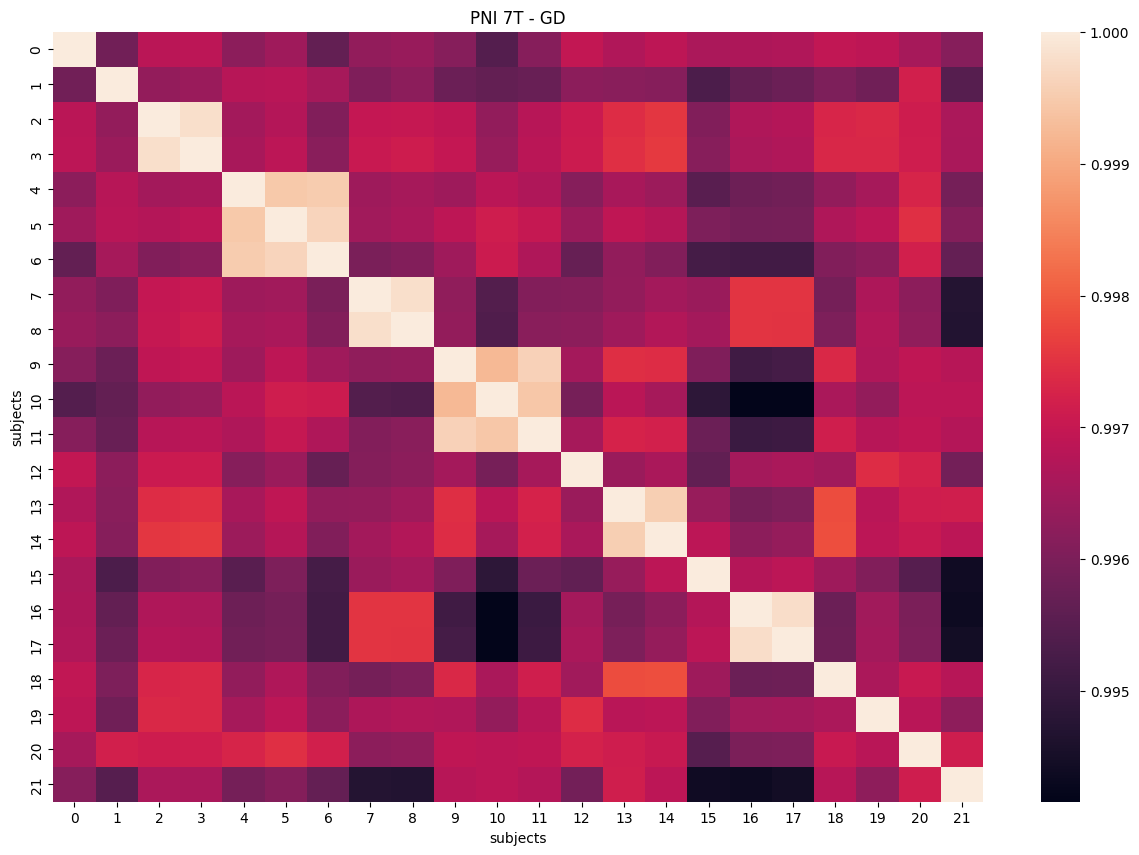

In [9]:
# whitin group similarity matrix
GDtri=np.empty([len(GD_files), vectorized_mtx(GD[:,:,0]).shape[0]], dtype=float)
for i, f in enumerate(GD_files):
    GDtri[i,:]=vectorized_mtx(GD[:,:,i])

# correlation matrix
GD_corr = np.corrcoef(GDtri)
plot_connectome(GD_corr, 'PNI 7T - GD', xlab='subjects', ylab='subjects')

# MP2RAGE qT1 - MPC

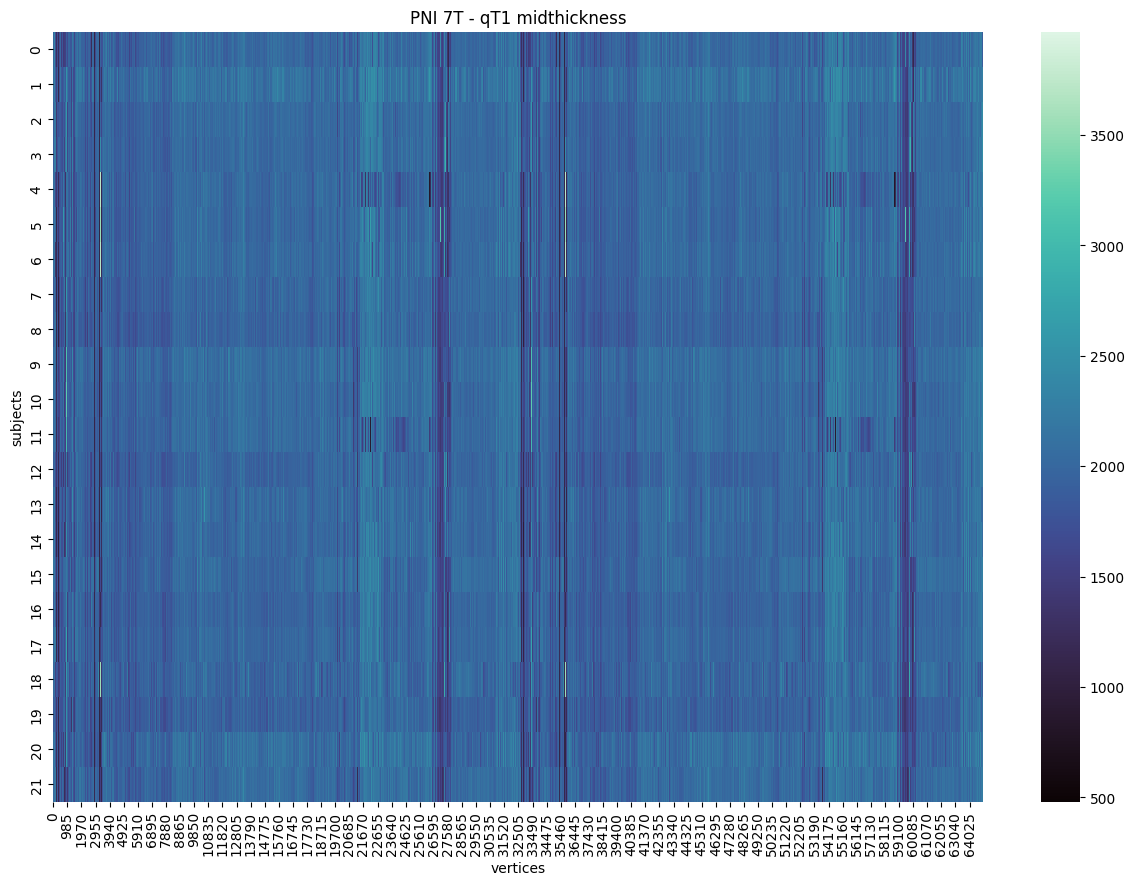

In [10]:
qt1_lh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-conte69-32k_desc-lh_MPC-7.mgh'))
qt1_rh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-conte69-32k_desc-lh_MPC-7.mgh'))

# Load all the thickness data
qt1_dim=np.hstack(np.concatenate((np.array(load(qt1_lh_files[0]).get_fdata()), np.array(load(qt1_rh_files[0]).get_fdata())), axis=0)).shape[1]

qt1=np.empty([len(qt1_lh_files), qt1_dim], dtype=float)
for i, f in enumerate(qt1_lh_files):
    #print(f)
    qt1[i,:] = np.hstack(np.concatenate((np.array(load(qt1_lh_files[i]).get_fdata()), np.array(load(qt1_rh_files[i]).get_fdata())), axis=0))

# Visualize the thickness matrix
plot_connectome(qt1, 'PNI 7T - qT1 midthickness', xlab='vertices', ylab='subjects', col='mako')

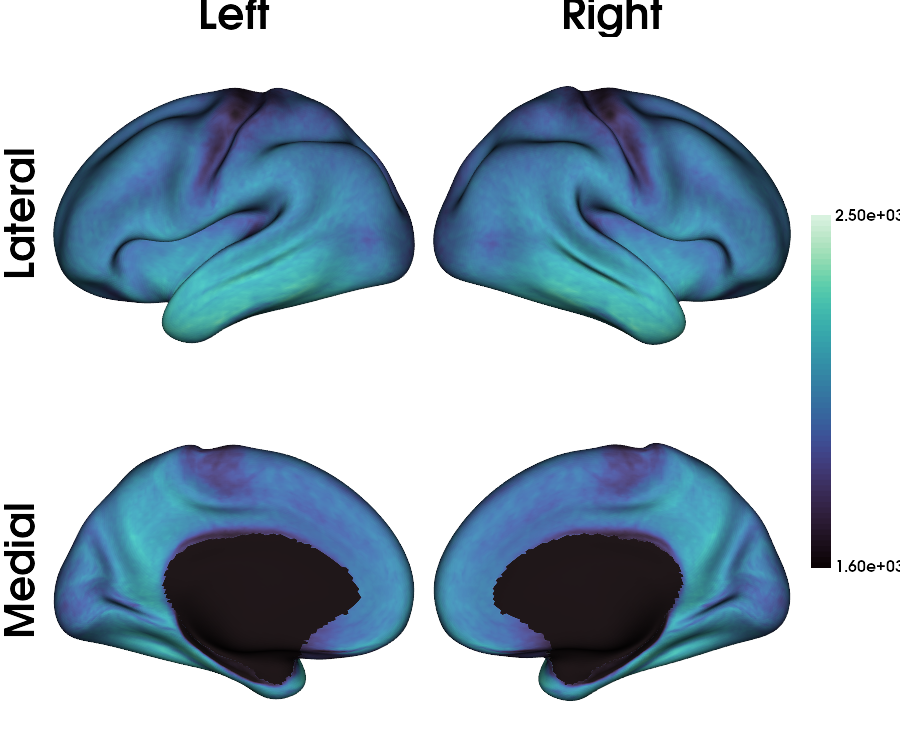

In [11]:
# Mean matrix across the x axis (vertices)
qt1mean = np.mean(qt1, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(inf_lh, inf_rh, array_name=qt1mean*mask_c69, cmap='mako', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1600, 2500),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_qt1_mean.png')

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_1486/348070376.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mtx_mpc = np.loadtxt(File, dtype=np.float, delimiter=' ')


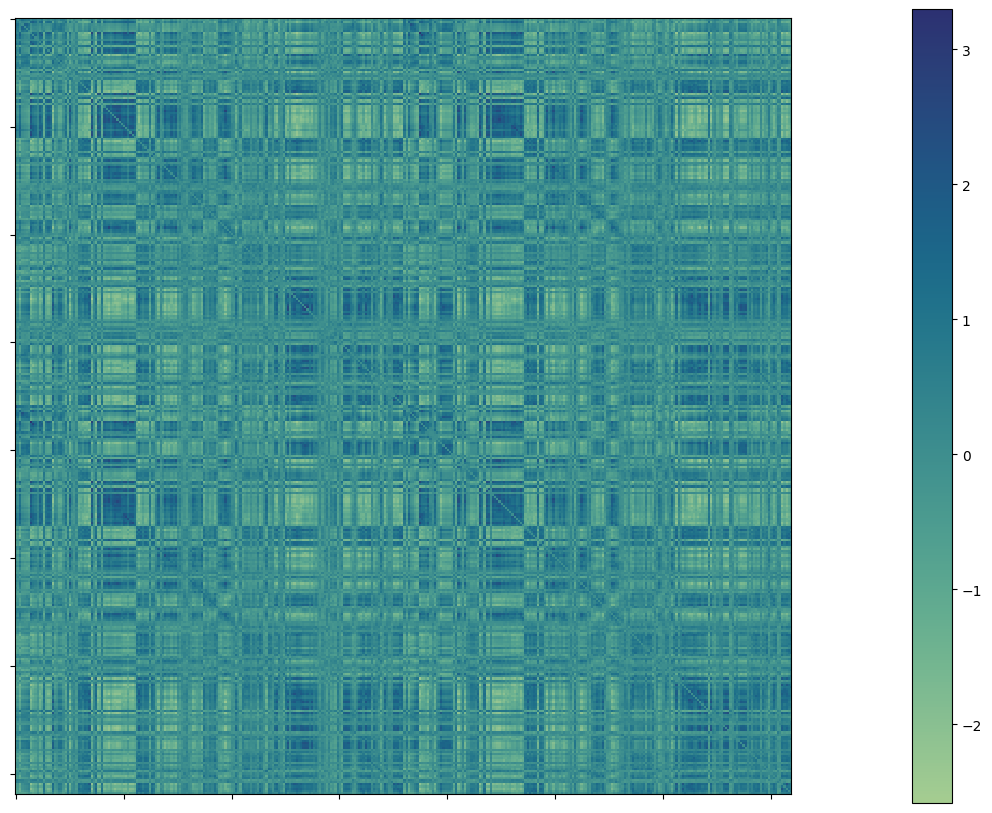

In [12]:
# list of all files
MPC_files = sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-fsnative_atlas-'+atlas+'_desc-MPC.txt'))

# Load all the  MPC matrices as array
MPC=np.empty([Ndim*2, Ndim*2, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC[:,:,i] = load_mpc(f, Ndim)

# Mean matrix across the z axis
MPCmean = np.mean(MPC, axis=2)

# Plot the matrix
plotting.plot_matrix(MPCmean, figure=(10, 10), labels=None, cmap='crest')


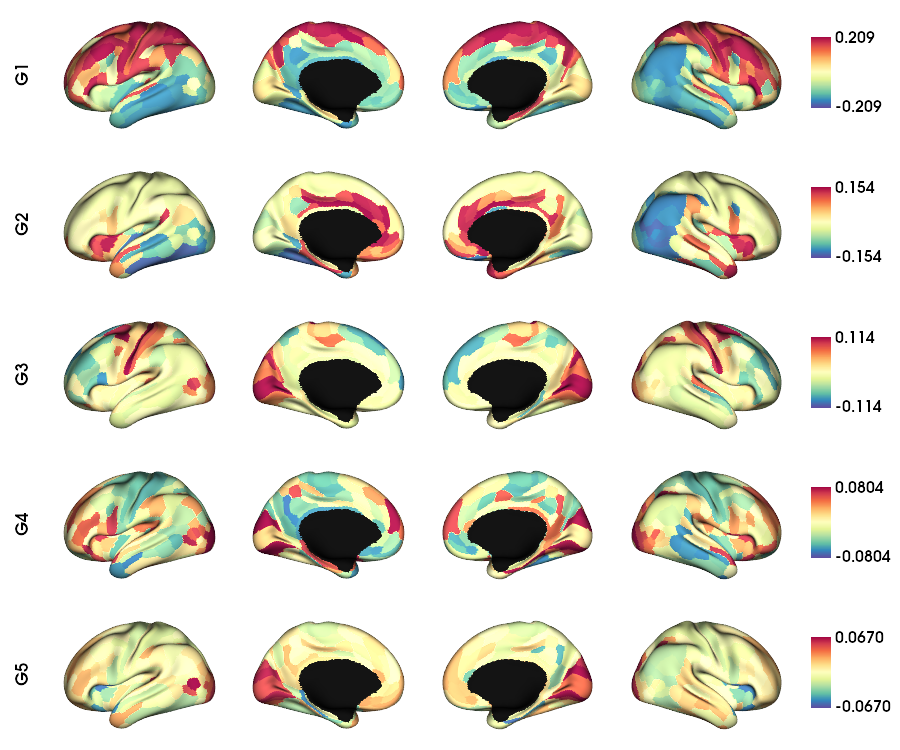

In [27]:
# Calculate the gradients
Ngrads=5
MPCgm = GradientMaps(n_components=Ngrads, random_state=None, approach='dm', kernel='normalized_angle')
MPCgm.fit(MPCmean, sparsity=0.9)

# Map gradients to original parcels
# other color 'RdYlBu_r'
grad = [None] * Ngrads
for i, g in enumerate(MPCgm.gradients_.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean_'+atlas+'.png')  

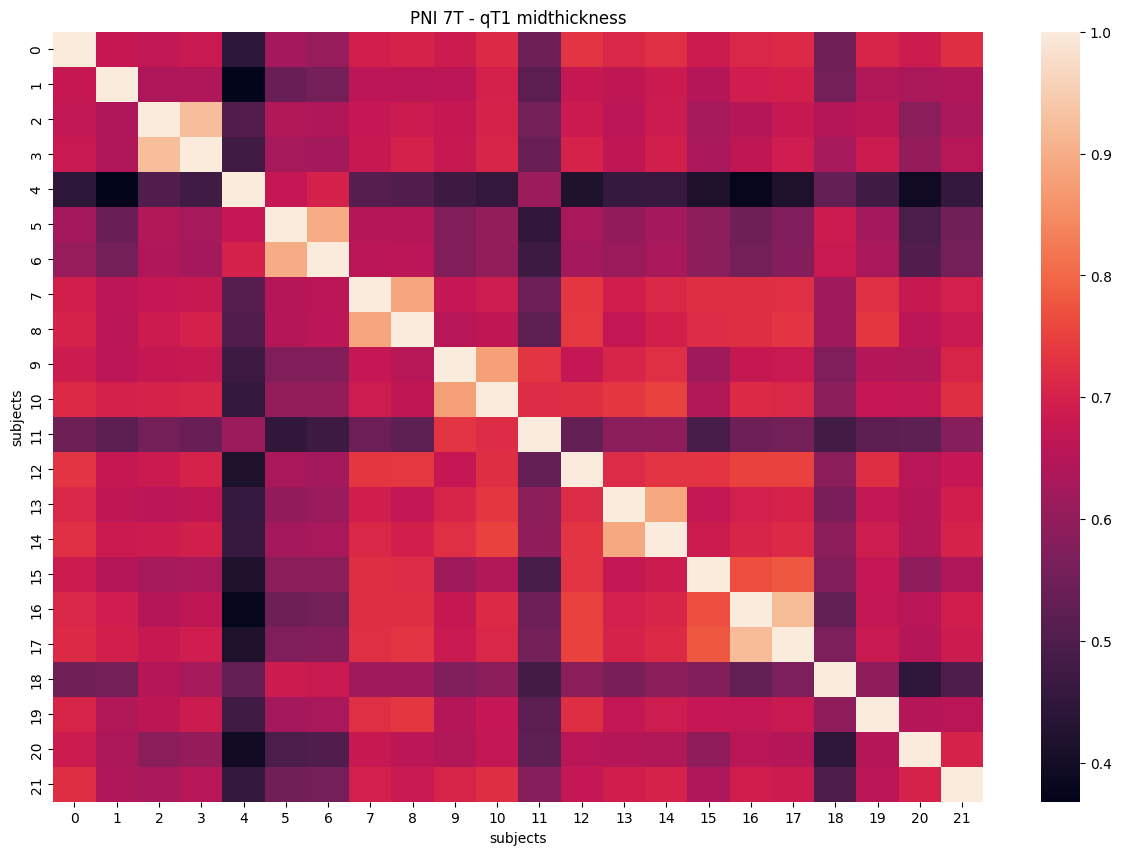

In [40]:
# correlation matrix
qt1_corr = np.corrcoef(qt1)
plot_connectome(qt1_corr, 'PNI 7T - qT1 midthickness', xlab='subjects', ylab='subjects')

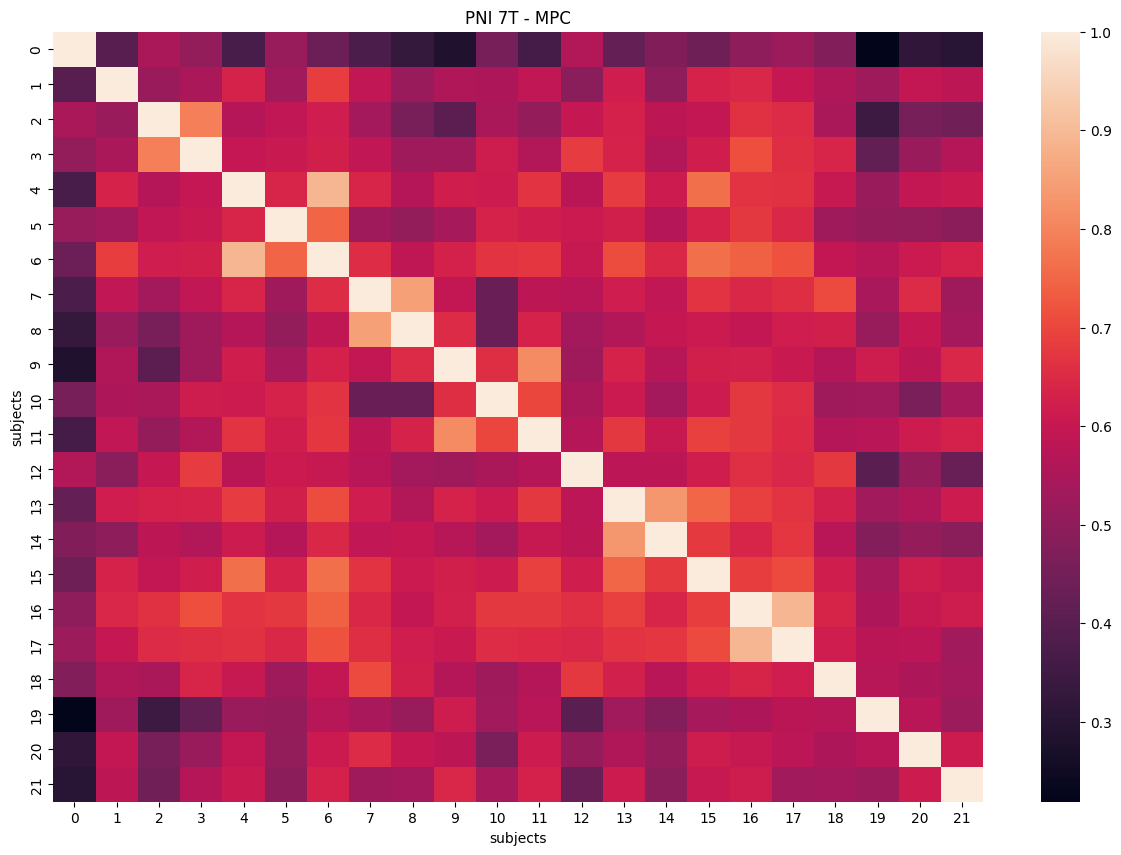

In [41]:
# Subject similarity matrix
MPCcol = np.mean(MPC, axis=0)
MPC_corr = np.corrcoef(MPCcol.T)
plot_connectome(MPC_corr, 'PNI 7T - MPC', xlab='subjects', ylab='subjects')

# Functional gradients

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_1486/348070376.py:101: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


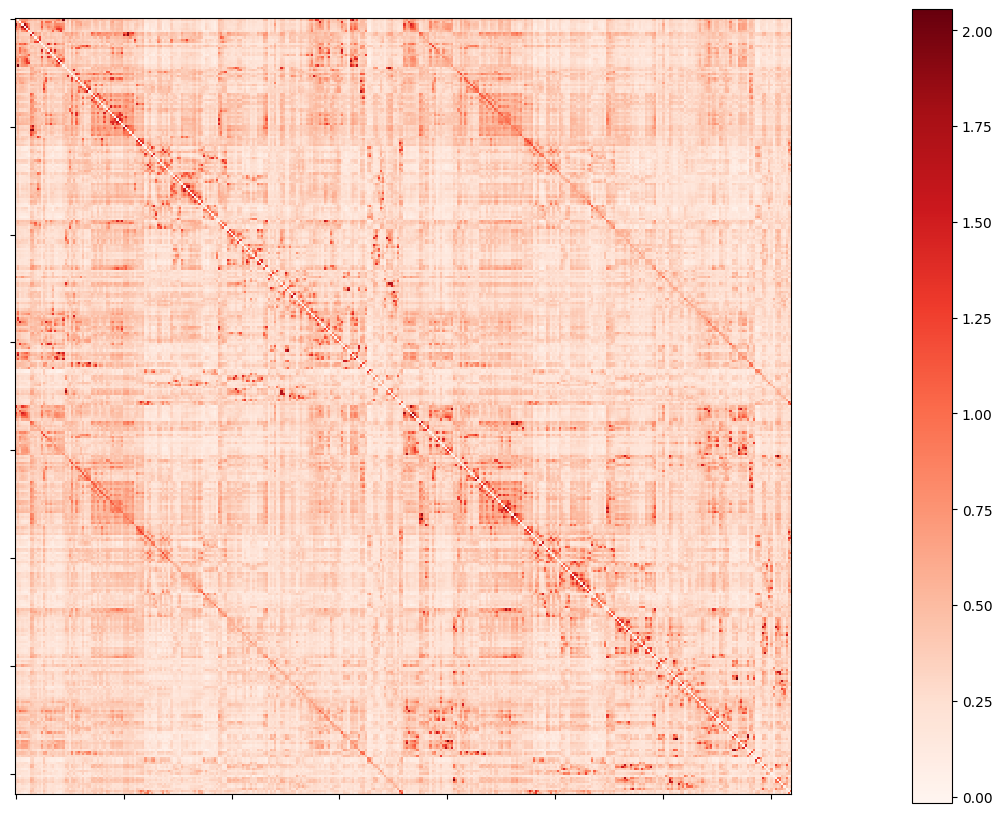

In [16]:
# list of all files
func_acq='desc-me_task-rest_bold'
fc_files = sorted(glob.glob('sub-*/ses-*/func/'+func_acq+'/surf/*_func_space-conte69-32k_atlas-' + atlas + '_desc-FC.txt'))

# Load all the  MPC matrices as array
fc=np.empty([Ndim*2, Ndim*2, len(fc_files)], dtype=float)
for i, f in enumerate(fc_files):
    #print(f)
    fc[:,:,i] = load_fc(f, Ndim, parc=atlas)

# Mean matrix across the z axis
FCmean = np.mean(fc, axis=2)

# Plot the matrix
plotting.plot_matrix(FCmean, figure=(10, 10), labels=None, cmap='Reds')

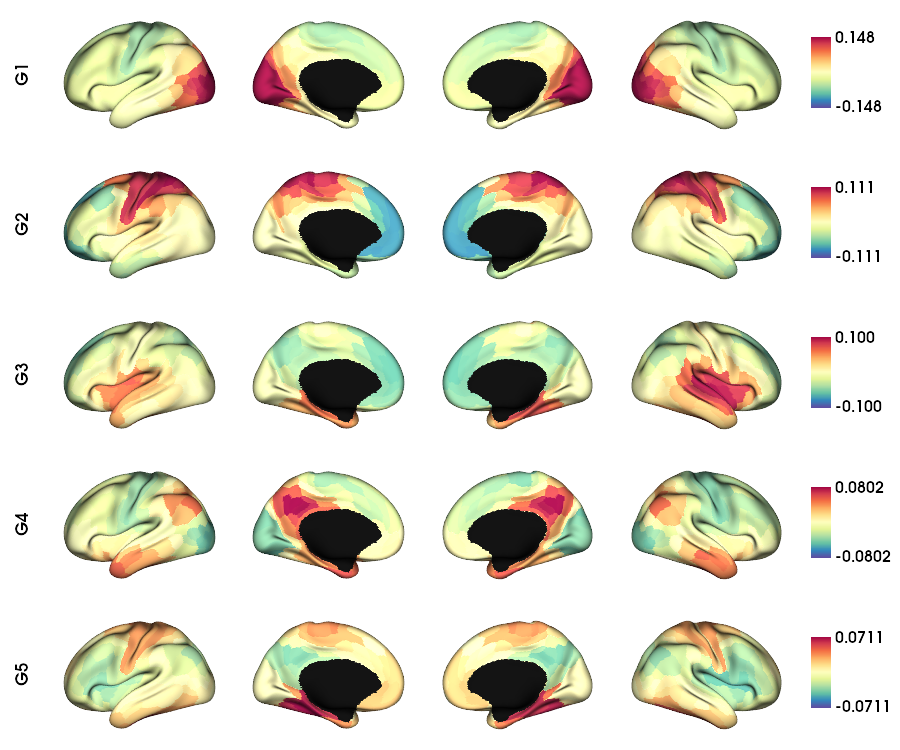

In [29]:
Ngrads=5
FCgm = GradientMaps(n_components=Ngrads, random_state=None, approach='dm', kernel='normalized_angle')
FCgm.fit(FCmean, sparsity=0.9)

# Map gradients to original parcels
# other color 'RdYlBu_r'
grad = [None] * Ngrads
for i, g in enumerate(FCgm.gradients_.T[0:Ngrads,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)
    
# plot gradients
labels=['G'+str(x) for x in list(range(1,Ngrads+1))]
plot_hemispheres(inf_lh, inf_rh, array_name=grad, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', 
  label_text={'left': labels},
  screenshot=False, filename='/home/bic/rcruces/Desktop/FC_mean_'+atlas+'.png')  

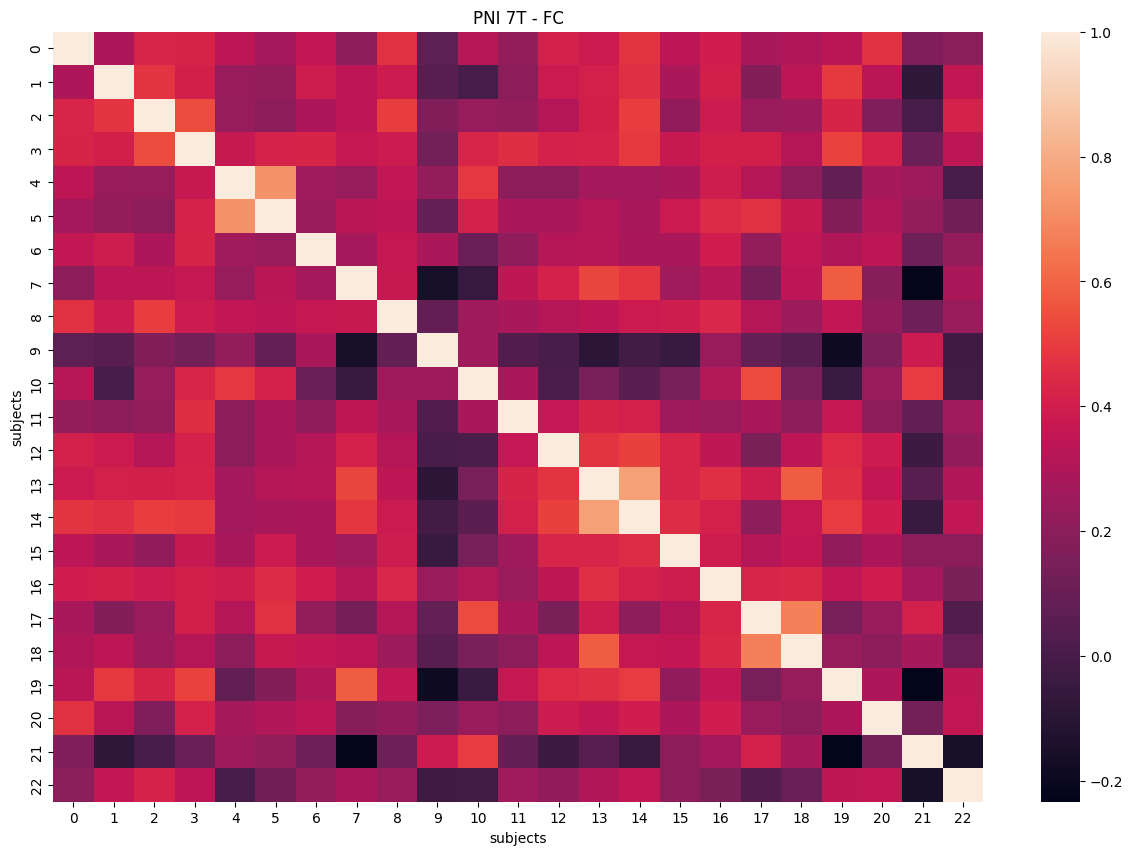

In [18]:
# correlation matrix
fccol = np.mean(fc, axis=0)
FC_corr = np.corrcoef(fccol.T)
plot_connectome(FC_corr, 'PNI 7T - FC', xlab='subjects', ylab='subjects')

# Structural Gradients